## [6주차 과제] 메타 러너

패널데이터를 이해, 활용하는 방법을 이해하기 위한 과제입니다.

---
**과제 가이드**

- date : 날짜
- city : 도시
- region : 지역
- treated : 광고 (처치변수)
- engagement : 참여도 (결과변수)
- 광고를 접한 후의 참여도를 확인하는 가상의 마케팅 사례 데이터입니다.
- 빈칸이 없는 부분은 확인용이니 확인 후 넘어가주세요.
---



과제 제출 기한: 2024년 7월 4일(목) 11:00<br>
제출 방법: `#24s-causal-inference` Slack 채널에 작성한 Notion 링크 공유<br>

*출제자: 정성윤, 유찬영<br>
최종 수정일: 2024년 6월 30일(일)*

# 8장 - 이중차분법


## 8.1 패널데이터


##### 라이브러리 및 함수 정의

In [1]:
from toolz import *

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

from cycler import cycler

color=['0.0', '0.4', '0.8']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

##### 데이터

In [2]:
import pandas as pd
import numpy as np

mkt_data = (pd.read_csv("./data/Processed_New_Dataset_1.csv")
            .astype({"date":"datetime64[ns]"}))

mkt_data.head()

,date,city,region,tau,engagement,post,treated
0,2021-05-01,5,S,2.956377,15.188282,0,0
1,2021-05-02,5,S,1.995014,40.820318,0,0
2,2021-05-03,5,S,0.273808,34.322292,0,0
3,2021-05-04,5,S,1.675986,96.977565,0,0
4,2021-05-05,5,S,4.014267,60.193794,0,0


In [3]:
(mkt_data
 .assign(w = lambda d: d["treated"]*d["post"])
 .groupby(["w"])
 .agg({"date":[min, max]}))

C:\Users\adsky\AppData\Local\Temp\ipykernel_29780\2583971365.py:4: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  .agg({"date":[min, max]}))
C:\Users\adsky\AppData\Local\Temp\ipykernel_29780\2583971365.py:4: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  .agg({"date":[min, max]}))


date           
         min        max
w                      
0 2021-05-01 2021-06-01
1 2021-05-15 2021-06-01

## 8.2 표준 이중차분법


In [4]:
did_data = (mkt_data
            .groupby(["treated", "post"])
            .agg({"engagement":"mean", "date": "min"}))           # 실험군과 대조군으로 나눈 후 평균 계산

did_data

engagement       date
treated post                       
0       0      54.596706 2021-05-01
        1      54.897817 2021-05-15
1       0      53.668182 2021-05-01
        1      55.905245 2021-05-15

반사실 추정값을 구한 후 ATT를 계산해주세요

In [5]:
y0_est = (did_data.loc[0].loc[0,'engagement']
          + did_data.loc[0].diff().loc[1, "engagement"])

In [6]:
att = did_data.loc[1].loc[1, "engagement"] - y0_est
att

1.0074285960491736

In [7]:
mkt_data.query("post==1").query("treated==1")["tau"].mean()

2.4684953305552253

### 8.2.1 이중차분법과 결과 변화


In [8]:
pre = mkt_data.query("post==0").groupby("city")["engagement"].mean()
post = mkt_data.query("post==1").groupby("city")["engagement"].mean()

delta_y = ((post - pre)
           .rename("delta_y")
           .to_frame()
           # 처치 더미 변수 추가
           .join(mkt_data.groupby("city")["treated"].max()))

delta_y.tail()

,delta_y,treated
city,,
192,-13.940096,0
193,3.781258,0
195,-4.640821,0
196,1.810509,1
197,-3.200238,0


In [9]:
(delta_y.query("treated==1")["delta_y"].mean() 
 - delta_y.query("treated==0")["delta_y"].mean())

1.9359520791988662

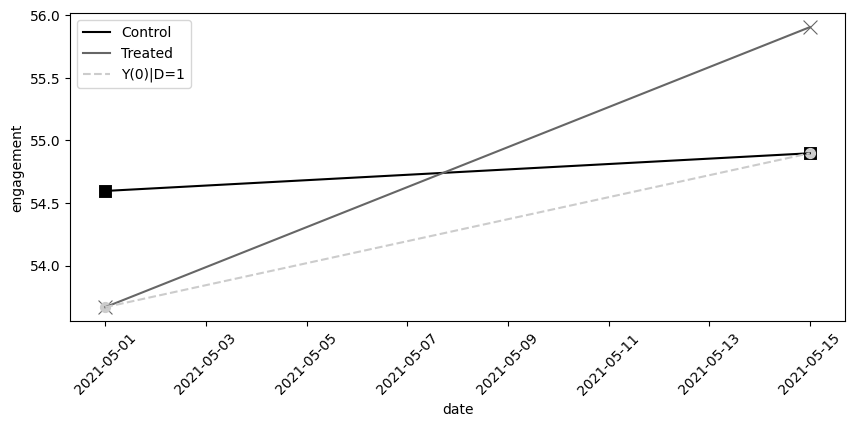

In [10]:
did_plt = did_data.reset_index()


plt.figure(figsize=(10,4))

sns.scatterplot(data=did_plt.query("treated==0"), x="date", y="engagement", s=100, color="C0", marker="s")
sns.lineplot(data=did_plt.query("treated==0"), x="date", y="engagement", label="Control", color="C0")

sns.scatterplot(data=did_plt.query("treated==1"), x="date", y="engagement", s=100, color="C1", marker="x")
sns.lineplot(data=did_plt.query("treated==1"), x="date", y="engagement", label="Treated", color="C1",)

plt.plot(did_data.loc[1, "date"], [did_data.loc[1, "engagement"][0], y0_est], color="C2", linestyle="dashed", label="Y(0)|D=1")
plt.scatter(did_data.loc[1, "date"], [did_data.loc[1, "engagement"][0], y0_est], color="C2", s=50)

plt.xticks(rotation = 45)
plt.legend()


# 질문 1
- 해당 그래프에서 ATT를 나타내는 포인트를 찾아주세요
- `Y(0)|D=1`는 어떻게 계산된 값인가요?

### 8.2.2 이중차분법과 OLS


포화회귀모델을 사용하여 DID 추정량을 구해주세요

In [16]:
did_data = (mkt_data
            .groupby(["city", "post"])
            .agg({"engagement":"mean", "date": "min", "treated": "max"})
            .reset_index())

did_data.head()

,city,post,engagement,date,treated
0,5,0,55.620541,2021-05-01,0
1,5,1,57.674248,2021-05-15,0
2,15,0,59.099635,2021-05-01,0
3,15,1,66.226177,2021-05-15,0
4,20,0,54.912513,2021-05-01,1


In [17]:
import statsmodels.formula.api as smf

smf.ols(
    'engagement ~ treated*post', data=did_data
).fit().params["treated:post"]

1.9359520791988878

### 8.2.3 이중차분법과 고정효과


더미변수를 사용하여 추정해주세요

In [18]:
m = smf.ols('engagement ~ treated:post + C(city) + C(post)',
            data=did_data).fit()

m.params["treated:post"]

1.935952079198829

# 질문 2

- `*`연산자에 대하여 자유롭게 서술해주세요

### 8.2.4 이중차분법과 블록 디자인


C:\Users\adsky\AppData\Local\Temp\ipykernel_25040\2644316852.py:7: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  .assign(treated=lambda d: d.groupby("city")["treated"].transform(max))


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5]),
 [Text(0.5, 0, '2021-05-01'),
  Text(1.5, 0, '2021-05-02'),
  Text(2.5, 0, '2021-05-03'),
  Text(3.5, 0, '2021-05-04'),
  Text(4.5, 0, '2021-05-05'),
  Text(5.5, 0, '2021-05-06'),
  Text(6.5, 0, '2021-05-07'),
  Text(7.5, 0, '2021-05-08'),
  Text(8.5, 0, '2021-05-09'),
  Text(9.5, 0, '2021-05-10'),
  Text(10.5, 0, '2021-05-11'),
  Text(11.5, 0, '2021-05-12'),
  Text(12.5, 0, '2021-05-13'),
  Text(13.5, 0, '2021-05-14'),
  Text(14.5, 0, '2021-05-15'),
  Text(15.5, 0, '2021-05-16'),
  Text(16.5, 0, '2021-05-17'),
  Text(17.5, 0, '2021-05-18'),
  Text(18.5, 0, '2021-05-19'),
  Text(19.5, 0, '2021-05-20'),
  Text(20.5, 0, '2021-05-21'),
  Text(21.5, 0, '2021-05-22'),
  Text(22.5, 0, '2021-05-23'),
  Text(23.5, 0, '2021-05-24'),
  Text(24.5, 0, '2021-05-25'),
  Text(25.5, 0, '

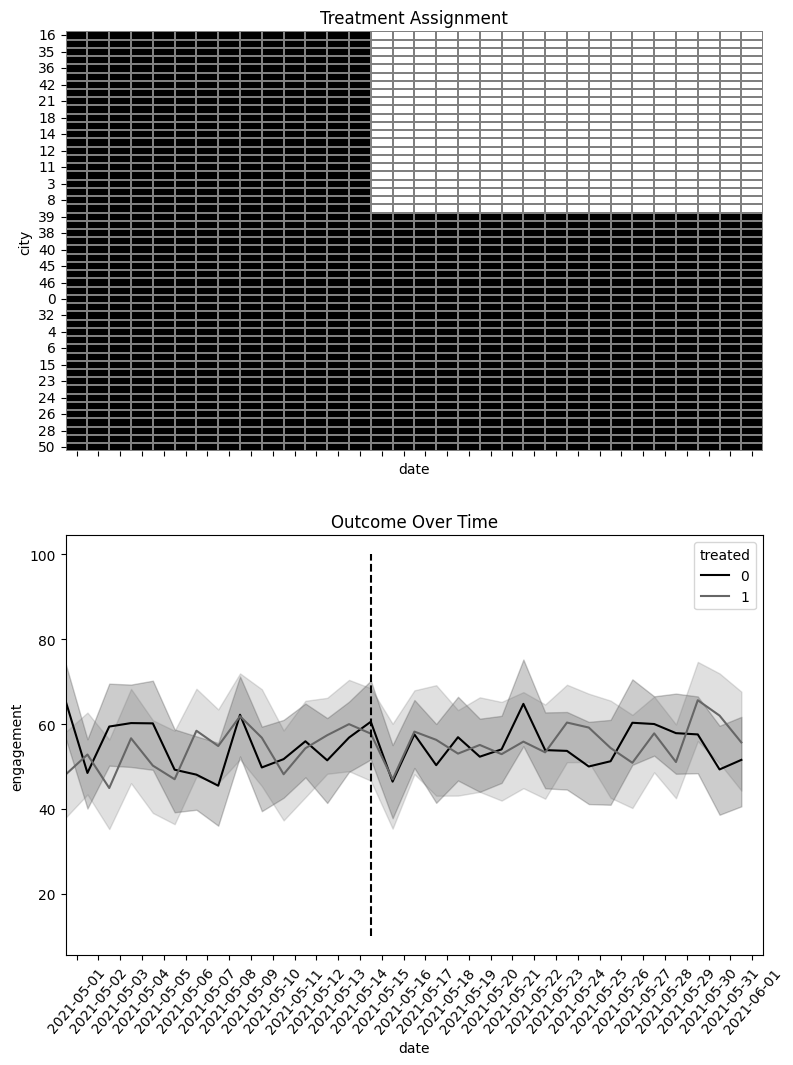

In [19]:
import matplotlib.ticker as plticker


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(9, 12), sharex=True)

heat_plt = (mkt_data
            .assign(treated=lambda d: d.groupby("city")["treated"].transform(max))
            .astype({"date":"str"})
            .assign(treated=mkt_data["treated"] * mkt_data["post"])
            .pivot(index="city", columns="date", values="treated")  # 여기서 수정
            .reset_index()
            .sort_values(by=max(mkt_data["date"].astype(str)), ascending=False)  # 정렬 부분도 수정 필요
            .reset_index()
            .drop(columns=["city"])
            .rename(columns={"index": "city"})
            .set_index("city"))



sns.heatmap(heat_plt, cmap="gray", linewidths=0.01, linecolor="0.5", ax=ax1, cbar=False)

ax1.set_title("Treatment Assignment")


sns.lineplot(data=mkt_data.astype({"date":"str"}),
             x="date", y="engagement", hue="treated", ax=ax2)

loc = plticker.MultipleLocator(base=2.0)
# ax2.xaxis.set_major_locator(loc)
ax2.vlines("2021-05-15", mkt_data["engagement"].min(), mkt_data["engagement"].max(), color="black", ls="dashed", label="Interv.")
ax2.set_title("Outcome Over Time")

plt.xticks(rotation = 50)

In [20]:
m = smf.ols('engagement ~ treated*post', data=mkt_data).fit()

m.params["treated:post"]

1.9359520791988825

In [21]:
m = smf.ols('engagement ~ treated:post + C(city) + C(date)',
            data=mkt_data).fit()

m.params["treated:post"]

1.935952079198845

### 8.2.5 추론


군집화 후 신뢰구간을 확인하고 기존 표준오차, 다른 데이터의 군집표준오차와 비교해주세요

In [23]:
m = smf.ols(
    'engagement ~ treated:post +C(city) + C(date)', data=mkt_data
).fit(cov_type='cluster', cov_kwds={'groups': mkt_data['city']})

print("ATT:", m.params["treated:post"])
m.conf_int().loc["treated:post"]

ATT: 1.935952079198845


0   -4.231428
1    8.103332
Name: treated:post, dtype: float64

In [24]:
m = smf.ols('engagement ~ treated:post +C(city) + C(date)',
            data=mkt_data).fit()

print("ATT:", m.params["treated:post"])
m.conf_int().loc["treated:post"]

ATT: 1.935952079198845


0   -3.214347
1    7.086251
Name: treated:post, dtype: float64

In [25]:
m = smf.ols(
    'engagement ~ treated:post +C(city) + C(date)', data=did_data
).fit(cov_type='cluster', cov_kwds={'groups': did_data['city']})

print("ATT:", m.params["treated:post"])
m.conf_int().loc["treated:post"]

ATT: 1.935952079198829


0    -6.693080
1    10.564984
Name: treated:post, dtype: float64

# 질문 3

- did_data에 대한 신뢰 구간이 기존 데이터(mkt_data)와 차이가 나는 이유를 자유롭게 설명해주세요

## 8.4 시간에 따른 효과 변동


In [29]:
def did_date(df, date):
    df_date = (df
               .query("date==@date | post==0")
               .query("date <= @date")
               .assign(post = lambda d: (d["date"]==date).astype(int)))
    
    m = smf.ols(
        'engagement ~ I(treated*post) + C(city) +C(date)', data=df_date
    ).fit(cov_type='cluster', cov_kwds={'groups': df_date['city']})
    
    att = m.params["I(treated * post)"]
    ci = m.conf_int().loc["I(treated * post)"]
    
    return pd.DataFrame({"att": att, "ci_low": ci[0], "ci_up": ci[1]},
                        index=[date])

In [30]:
post_dates = sorted(mkt_data["date"].unique())[1:]

atts = pd.concat([did_date(mkt_data, date)
                  for date in post_dates])

atts.head()

,att,ci_low,ci_up
2021-05-02,21.650763,-0.489003,43.790529
2021-05-03,-7.999099,-30.333007,14.334810
2021-05-04,5.568395,-16.923986,28.060776
2021-05-05,-2.194704,-20.010146,15.620738
2021-05-06,5.954432,-10.305875,22.214739


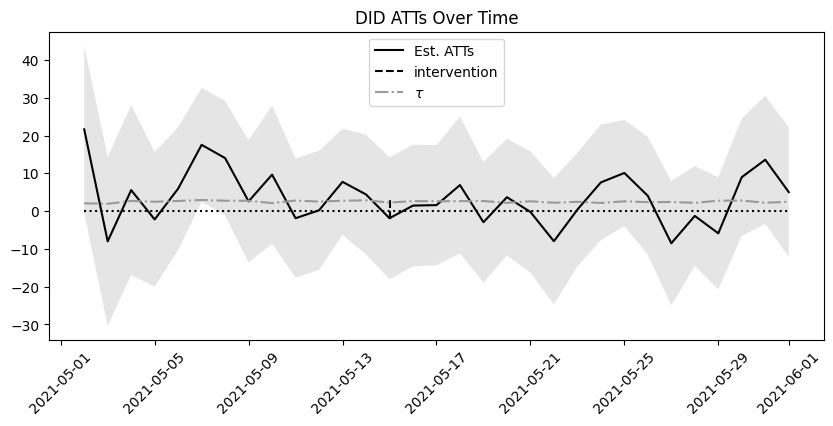

In [31]:

plt.figure(figsize=(10,4))
plt.plot(atts.index, atts["att"], label="Est. ATTs")

plt.fill_between(atts.index, atts["ci_low"], atts["ci_up"], alpha=0.1)

plt.vlines(pd.to_datetime("2021-05-15"), -2, 3, linestyle="dashed", label="intervention")
plt.hlines(0, atts.index.min(), atts.index.max(), linestyle="dotted")

plt.plot(atts.index, mkt_data.query("treated==1").groupby("date")[["tau"]].mean().values[1:], color="0.6", ls="-.", label="$\\tau$")

plt.xticks(rotation=45)
plt.title("DID ATTs Over Time")
plt.legend()


## 8.5 이중차분법과 공변량


In [32]:
mkt_data_all = (pd.read_csv("./data/Processed_New_Dataset_2.csv")
                .astype({"date":"datetime64[ns]"}))

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


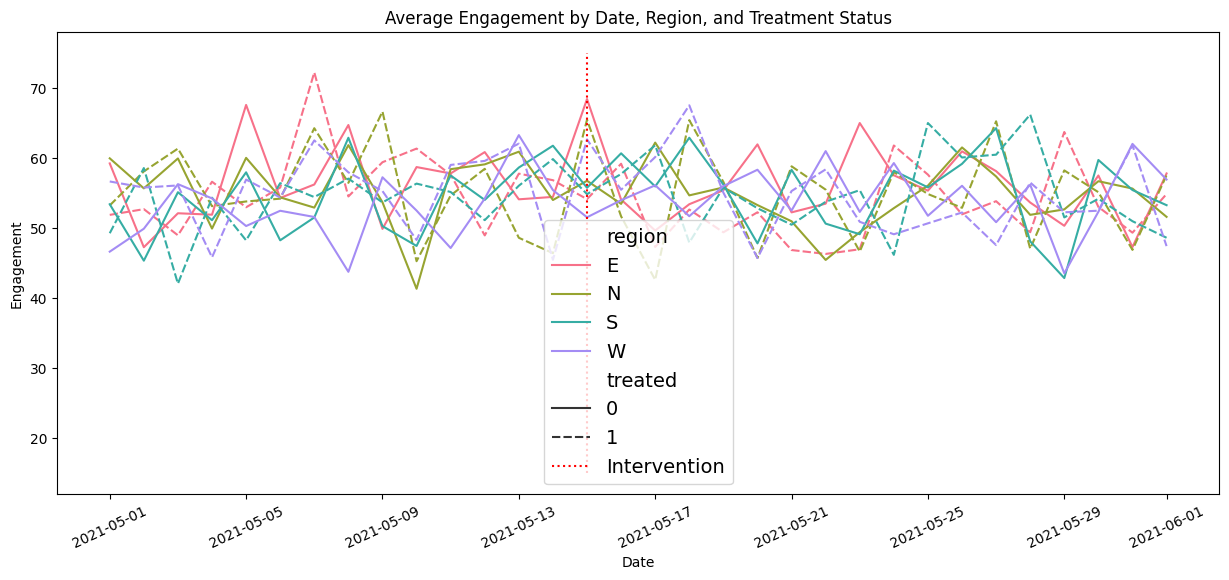

In [35]:
# 그래프 그리기
plt.figure(figsize=(15,6))
sns.lineplot(data=mkt_data_all.groupby(["date", "region", "treated"])[["engagement"]].mean().reset_index(),
             x="date", y="engagement", hue="region", style="treated", 
             palette=sns.color_palette("husl", n_colors=4))  # 각 지역에 다른 색상을 부여

# 개입 시점 표시
plt.vlines(pd.to_datetime("2021-05-15"), 15, 75, ls="dotted", label="Intervention", colors='red')  # 색상 수정

# 레전드와 기타 설정
plt.legend(fontsize=14)
plt.xticks(rotation=25)
plt.title("Average Engagement by Date, Region, and Treatment Status")
plt.xlabel("Date")
plt.ylabel("Engagement")
plt.show()

(array([18748., 18752., 18756., 18760., 18764., 18768., 18772., 18776.,
        18779.]),
 [Text(18748.0, 0, '2021-05-01'),
  Text(18752.0, 0, '2021-05-05'),
  Text(18756.0, 0, '2021-05-09'),
  Text(18760.0, 0, '2021-05-13'),
  Text(18764.0, 0, '2021-05-17'),
  Text(18768.0, 0, '2021-05-21'),
  Text(18772.0, 0, '2021-05-25'),
  Text(18776.0, 0, '2021-05-29'),
  Text(18779.0, 0, '2021-06-01')])

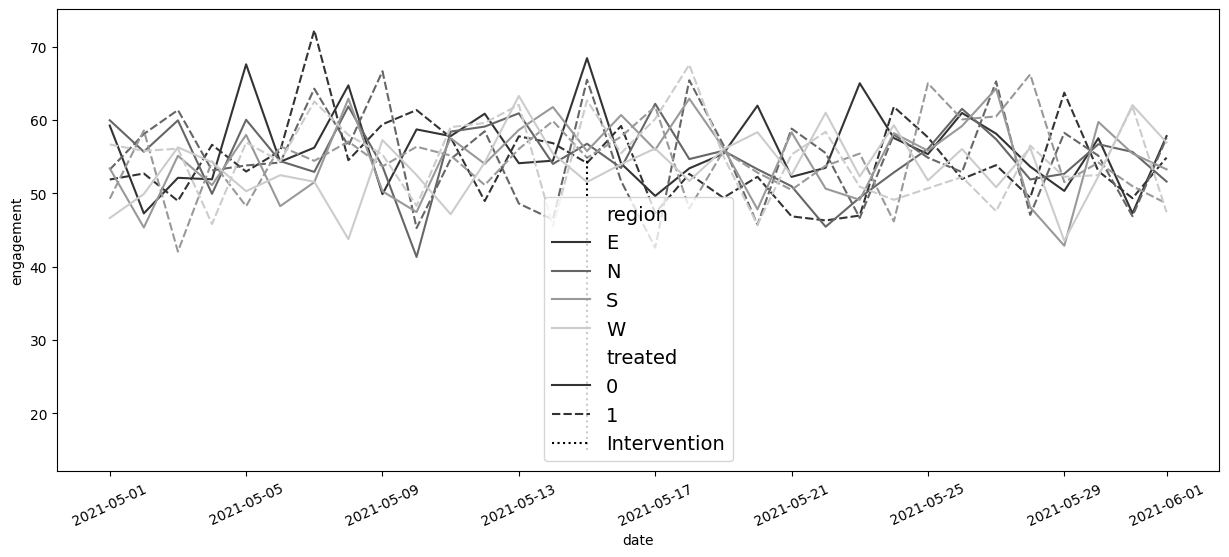

In [33]:
plt.figure(figsize=(15,6))
sns.lineplot(data=mkt_data_all.groupby(["date", "region", "treated"])[["engagement"]].mean().reset_index(),
             x="date", y="engagement", hue="region", style="treated", palette="gray")

plt.vlines(pd.to_datetime("2021-05-15"), 15, 55, ls="dotted", label="Intervention")
plt.legend(fontsize=14)

plt.xticks(rotation=25)

In [37]:
print("True ATT: ", mkt_data_all.query("treated*post==1")["tau"].mean())

m = smf.ols('engagement ~ treated:post + C(city) + C(date)',
            data=mkt_data_all).fit()

print("Estimated ATT:", m.params['treated:post'])

True ATT:  2.46097687747784
Estimated ATT: -0.9285184871425933


In [38]:
# 지역 공변량을 추가해서 확인해 보세요!
m = smf.ols('engagement ~ treated:post + C(city) + C(date) + C(region)',
            data=mkt_data_all).fit()
m.params["treated:post"] 

-0.9192250845291621

In [40]:
# 지역 더미 변수를 활용해서 채워주세요!
m_saturated = smf.ols('engagement ~ (post*treated)*C(region)',
                      data=mkt_data_all).fit()

atts = m_saturated.params[m_saturated.params.index.str.contains("post:treated")]
atts

post:treated                  -3.220366
post:treated:C(region)[T.N]    4.379631
post:treated:C(region)[T.S]    4.274906
post:treated:C(region)[T.W]    0.438865
dtype: float64

In [41]:
reg_size = (mkt_data_all.groupby("region").size()
            /len(mkt_data_all["date"].unique()))

base = atts[0]

np.array([reg_size[0]*base]+
         [(att+base)*size
          for att, size in zip(atts[1:], reg_size[1:])]
        ).sum()/sum(reg_size)

C:\Users\adsky\AppData\Local\Temp\ipykernel_25040\423212460.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  base = atts[0]
C:\Users\adsky\AppData\Local\Temp\ipykernel_25040\423212460.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.array([reg_size[0]*base]+


-0.9456044440849323

# 질문 3
- 현 상황에서 위와 같은 방법을 수행하는 것이 아래의 방법보다 실용적일까요?

In [42]:
m = smf.ols('engagement ~ post*(treated + C(region))',
            data=mkt_data_all).fit()

m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.1115,1.077,52.076,0.000,53.999,58.224
C(region)[T.N],-0.1478,1.418,-0.104,0.917,-2.928,2.633
C(region)[T.S],-2.2174,1.388,-1.598,0.110,-4.937,0.503
C(region)[T.W],-2.2006,1.385,-1.589,0.112,-4.916,0.515
post,-0.8255,1.442,-0.572,0.567,-3.652,2.001
post:C(region)[T.N],-0.4297,1.882,-0.228,0.819,-4.120,3.260
post:C(region)[T.S],2.6180,1.859,1.408,0.159,-1.026,6.262
post:C(region)[T.W],1.8435,1.861,0.991,0.322,-1.805,5.492
treated,0.1992,1.000,0.199,0.842,-1.762,2.160
post:treated,-0.9343,1.334,-0.701,0.484,-3.549,1.680


## 8.7 처치의 시차 도입

# 질문 4
- 시차 도입시 고려해야할 사항에 대해서 자유롭게 써주세요!

In [50]:
mkt_data_cohorts = (pd.read_csv("./data/Processed_New_Dataset_3.csv")
                    .astype({
                        "date":"datetime64[ns]",
                        "cohort":"datetime64[ns]"}))

mkt_data_cohorts.head()

,date,city,region,cohort,treated,tau,engagement,post
0,2021-05-01,1,W,2021-06-20,1,0.0,27.0,0
1,2021-05-02,1,W,2021-06-20,1,0.0,28.0,0
2,2021-05-03,1,W,2021-06-20,1,0.0,28.0,0
3,2021-05-04,1,W,2021-06-20,1,0.0,26.0,0
4,2021-05-05,1,W,2021-06-20,1,0.0,28.0,0


C:\Users\adsky\AppData\Local\Temp\ipykernel_25040\1774110236.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  .sort_values(by=list(sorted(mkt_data_cohorts.query("cohort!='2100-01-01'")["cohort"].astype("str").unique())), ascending=False)


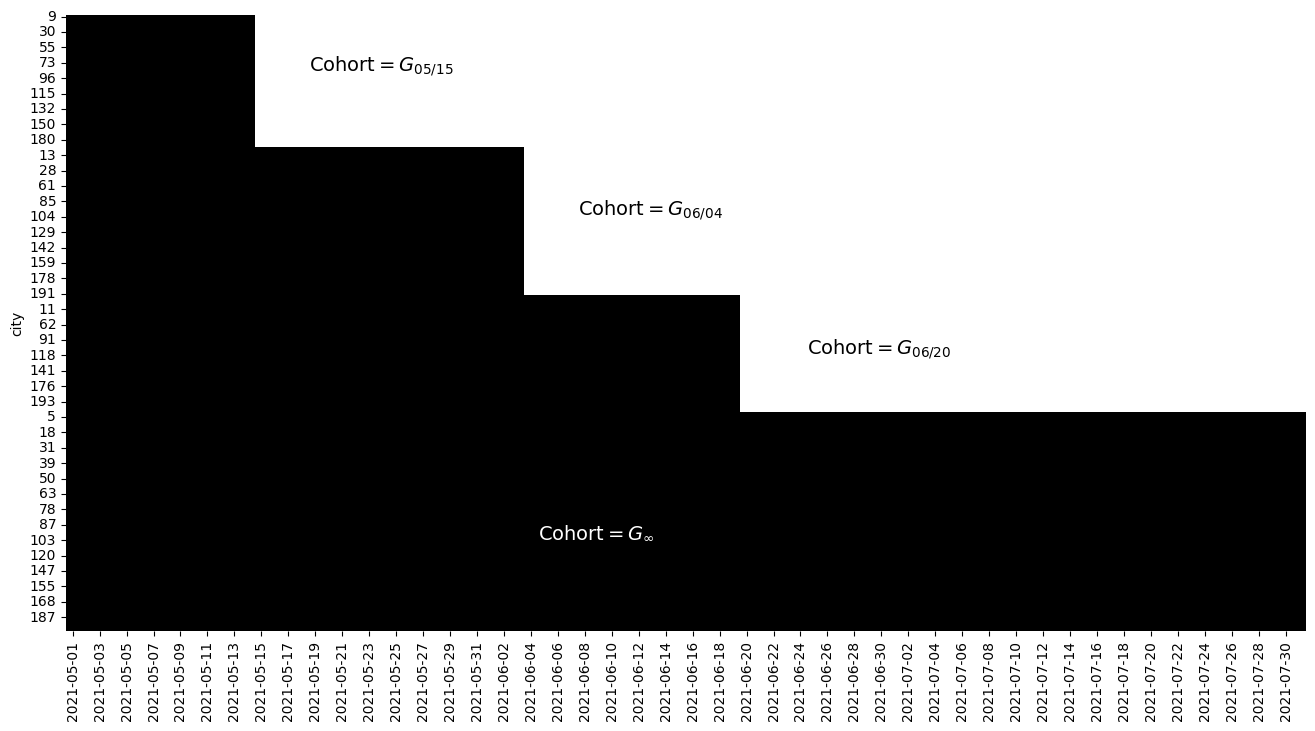

In [44]:
plt_data = (mkt_data_cohorts
            .astype({"date": "str"})
            .assign(treated_post=lambda d: d["treated"] * (d["date"] >= d["cohort"]))
            .pivot(index="city", columns="date", values="treated_post")
            .reset_index()
            .sort_values(by=list(sorted(mkt_data_cohorts.query("cohort!='2100-01-01'")["cohort"].astype("str").unique())), ascending=False)
            .reset_index(drop=True)
            .rename_axis(None, axis=1)
            .set_index("city"))



plt.figure(figsize=(16,8))

sns.heatmap(plt_data, cmap="gray",cbar=False)
plt.text(18, 18, "Cohort$=G_{05/15}$", size=14)
plt.text(38, 65, "Cohort$=G_{06/04}$", size=14)
plt.text(55, 110, "Cohort$=G_{06/20}$", size=14)
plt.text(35, 170, "Cohort$=G_{\\infty}$", color="white", size=14, weight=3);

In [73]:
mkt_data_cohorts_w = mkt_data_cohorts.query("region=='W'")
mkt_data_cohorts_w.head()

,date,city,region,cohort,treated,tau,engagement,post
0,2021-05-01,1,W,2021-06-20,1,0.0,27.0,0
1,2021-05-02,1,W,2021-06-20,1,0.0,28.0,0
2,2021-05-03,1,W,2021-06-20,1,0.0,28.0,0
3,2021-05-04,1,W,2021-06-20,1,0.0,26.0,0
4,2021-05-05,1,W,2021-06-20,1,0.0,28.0,0


C:\Users\adsky\AppData\Local\Temp\ipykernel_25040\4139521253.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  for color, cohort in zip(["C0", "C1", "C2", "C3"], mkt_data_cohorts_w.query("cohort!='2100-01-01'")["cohort"].unique()):
C:\Users\adsky\AppData\Local\Temp\ipykernel_25040\4139521253.py:19: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  sns.lineplot(data=plt_data.query("cohort=='2100-01-01'"), x="date", y="engagement", label="$\infty$", lw=4, ls="-.", ax=ax1)
C:\Users\adsky\AppData\Local\Temp\ipykernel_25040\4139521253.py:34: FutureWarning: The behavior of 'isin' with

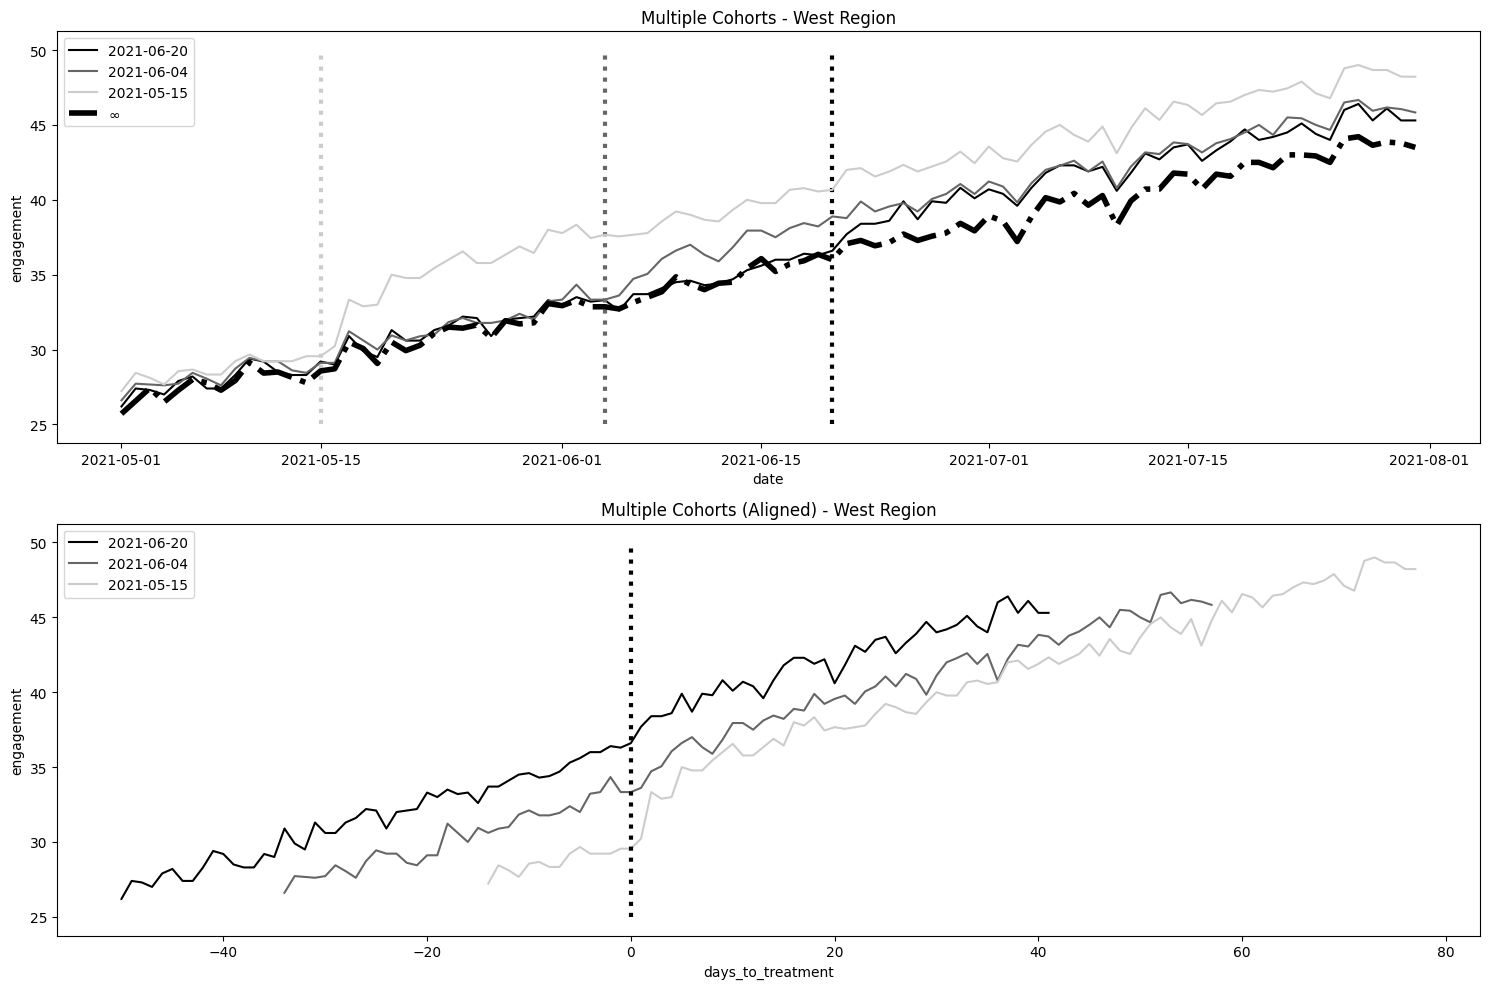

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

plt_data = (mkt_data_cohorts_w
            .groupby(["date", "cohort"])
            [["engagement"]]
            .mean()
            .reset_index()
)



for color, cohort in zip(["C0", "C1", "C2", "C3"], mkt_data_cohorts_w.query("cohort!='2100-01-01'")["cohort"].unique()):
    df_cohort = plt_data.query("cohort==@cohort")
    sns.lineplot(data=df_cohort, x="date", y="engagement",
                 label=pd.to_datetime(cohort).strftime('%Y-%m-%d'), ax=ax1)
    ax1.vlines(x=cohort, ymin=25, ymax=50, color=color, ls="dotted", lw=3)
    
    
sns.lineplot(data=plt_data.query("cohort=='2100-01-01'"), x="date", y="engagement", label="$\infty$", lw=4, ls="-.", ax=ax1)
        
ax1.legend()
ax1.set_title("Multiple Cohorts - West Region");


plt_data = (mkt_data_cohorts_w
            .assign(days_to_treatment = lambda d: (pd.to_datetime(d["date"])-pd.to_datetime(d["cohort"])).dt.days)
            .groupby(["date", "cohort"])
            [["engagement", "days_to_treatment"]]
            .mean()
            .reset_index()
)


for color, cohort in zip(["C0", "C1", "C2", "C3"], mkt_data_cohorts_w.query("cohort!='2100-01-01'")["cohort"].unique()):
    df_cohort = plt_data.query("cohort==@cohort")
    sns.lineplot(data=df_cohort, x="days_to_treatment", y="engagement",
                 label=pd.to_datetime(cohort).strftime('%Y-%m-%d'), ax=ax2)

ax2.vlines(x=0, ymin=25, ymax=50, color="black", ls="dotted", lw=3)

ax2.set_title("Multiple Cohorts (Aligned) - West Region")
ax2.legend();

plt.tight_layout()

C:\Users\adsky\AppData\Local\Temp\ipykernel_25040\1262072433.py:20: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  for color, cohort in zip(cohort_colors, mkt_data_cohorts_w.query("cohort!='2100-01-01'")["cohort"].unique()):
C:\Users\adsky\AppData\Local\Temp\ipykernel_25040\1262072433.py:26: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  sns.lineplot(data=plt_data.query("cohort=='2100-01-01'"), x="date", y="engagement", label="$\infty$", lw=4, ls="-.", ax=ax1, color="black")
C:\Users\adsky\AppData\Local\Temp\ipykernel_25040\1262072433.py:39: FutureWarning: The behavior of 'isin' 

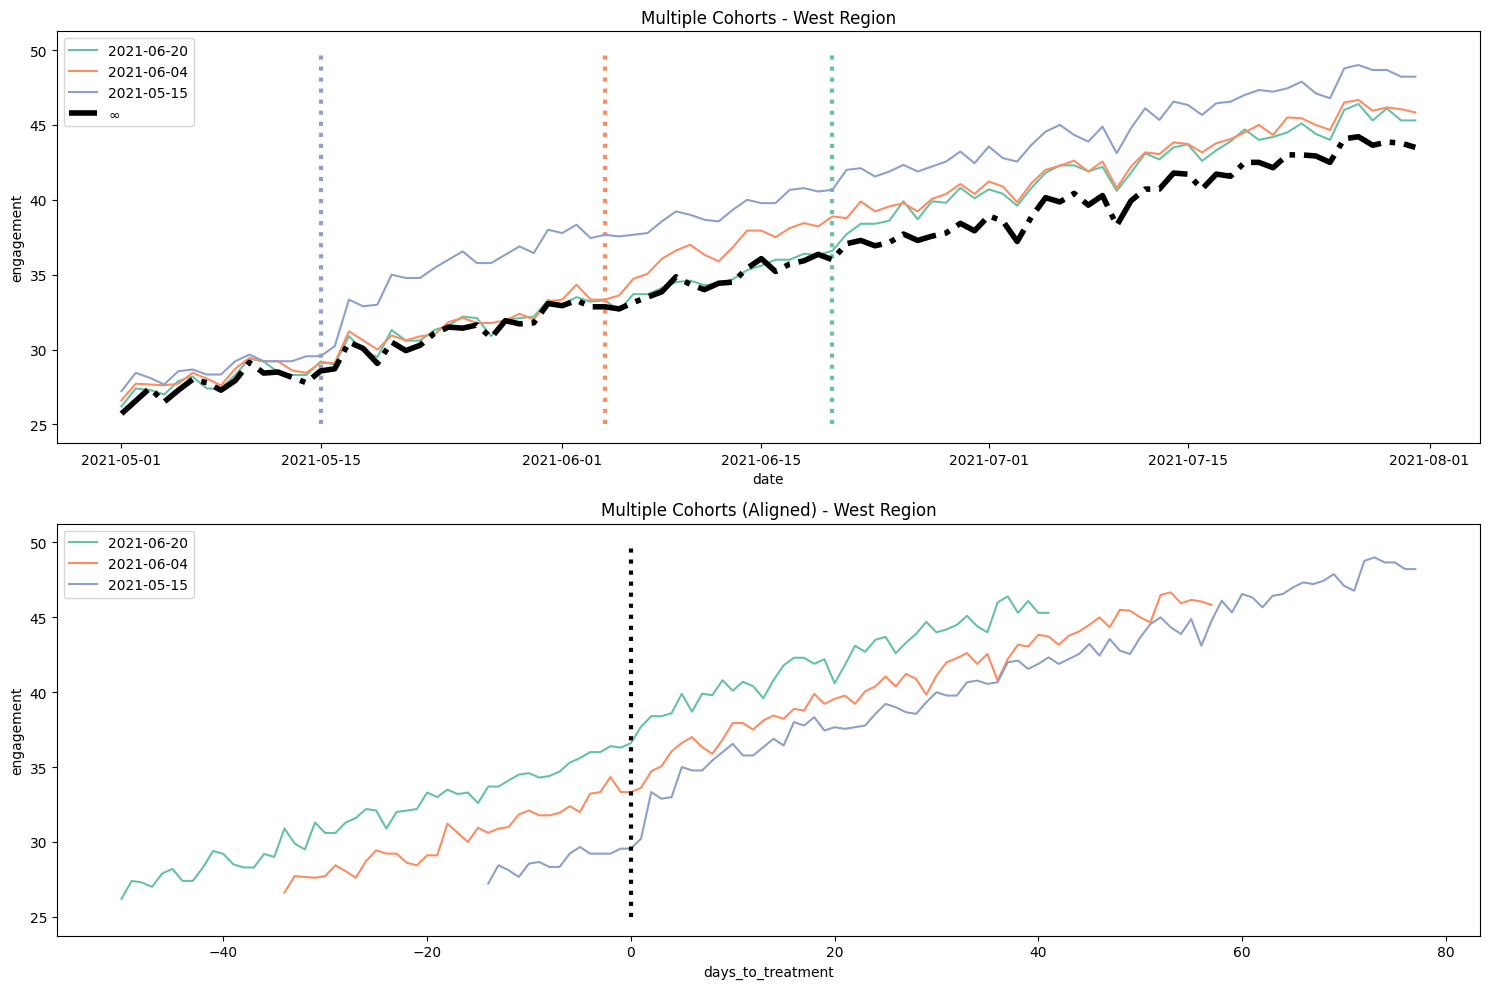

In [63]:
#3## 색 보이게

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 색상 리스트 정의
palette = sns.color_palette("Set2", n_colors=4)
cohort_colors = [palette[0], palette[1], palette[2], palette[3]]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

plt_data = (mkt_data_cohorts_w
            .groupby(["date", "cohort"])
            [["engagement"]]
            .mean()
            .reset_index()
)

for color, cohort in zip(cohort_colors, mkt_data_cohorts_w.query("cohort!='2100-01-01'")["cohort"].unique()):
    df_cohort = plt_data.query("cohort==@cohort")
    sns.lineplot(data=df_cohort, x="date", y="engagement",
                 label=pd.to_datetime(cohort).strftime('%Y-%m-%d'), ax=ax1, color=color)
    ax1.vlines(x=cohort, ymin=25, ymax=50, color=color, ls="dotted", lw=3)

sns.lineplot(data=plt_data.query("cohort=='2100-01-01'"), x="date", y="engagement", label="$\infty$", lw=4, ls="-.", ax=ax1, color="black")

ax1.legend()
ax1.set_title("Multiple Cohorts - West Region")

plt_data = (mkt_data_cohorts_w
            .assign(days_to_treatment = lambda d: (pd.to_datetime(d["date"])-pd.to_datetime(d["cohort"])).dt.days)
            .groupby(["date", "cohort"])
            [["engagement", "days_to_treatment"]]
            .mean()
            .reset_index()
)

for color, cohort in zip(cohort_colors, mkt_data_cohorts_w.query("cohort!='2100-01-01'")["cohort"].unique()):
    df_cohort = plt_data.query("cohort==@cohort")
    sns.lineplot(data=df_cohort, x="days_to_treatment", y="engagement",
                 label=pd.to_datetime(cohort).strftime('%Y-%m-%d'), ax=ax2, color=color)

ax2.vlines(x=0, ymin=25, ymax=50, color="black", ls="dotted", lw=3)

ax2.set_title("Multiple Cohorts (Aligned) - West Region")
ax2.legend()

plt.tight_layout()
plt.show()


In [74]:
twfe_model = smf.ols(
    "engagement ~ treated:post + C(date) + C(city)",
    data=mkt_data_cohorts_w
).fit()

true_tau = mkt_data_cohorts_w.query("post==1&treated==1")["tau"].mean()

print("True Effect: ", true_tau)
print("Estimated ATT:", twfe_model.params["treated:post"])

True Effect:  2.2625252108176266
Estimated ATT: 1.759950478063391


C:\Users\adsky\AppData\Local\Temp\ipykernel_25040\80203400.py:11: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  .query(f"cohort=='{cohort_late}' | cohort=='{cohort_erly}'")
C:\Users\adsky\AppData\Local\Temp\ipykernel_25040\80203400.py:46: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  .query(f"cohort=='{cohort_late}' | cohort=='{cohort_erly}'")


Text(0.5, 1.0, 'Late vs Early')

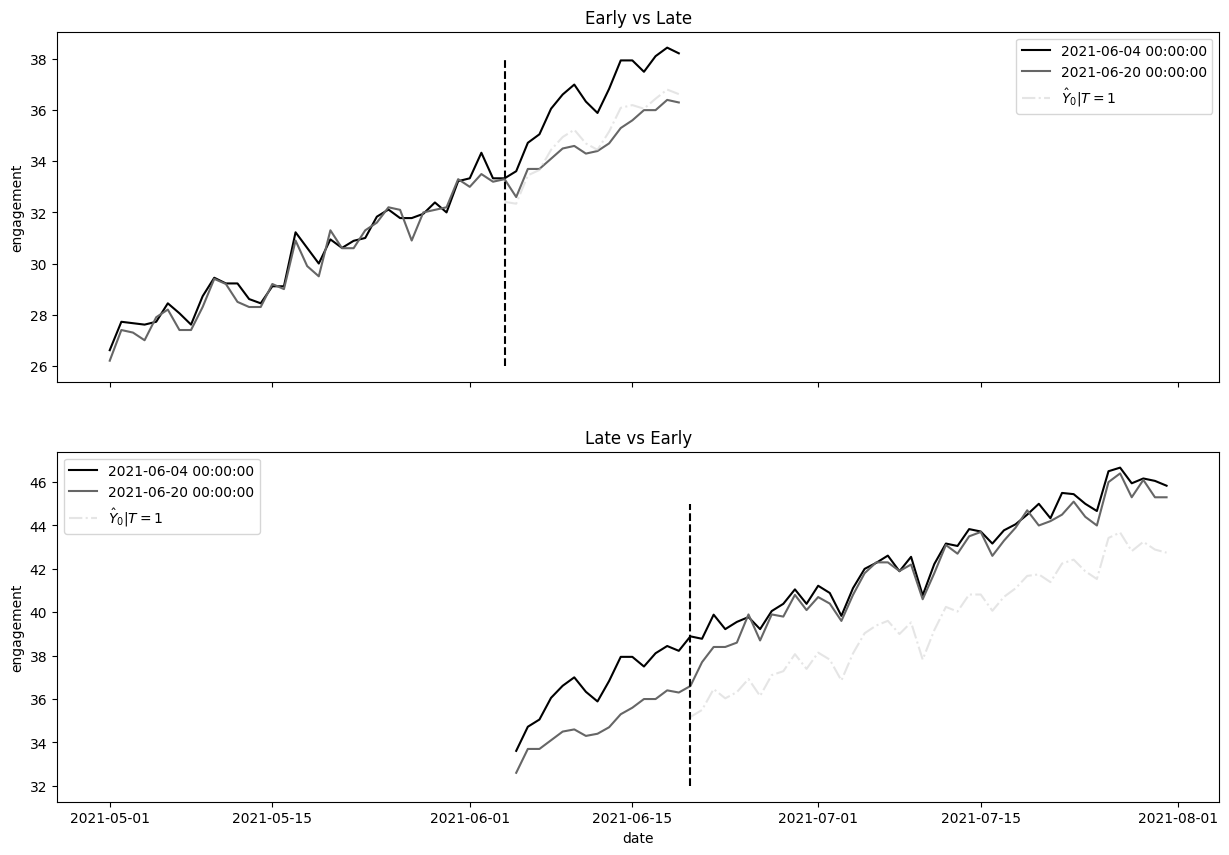

In [76]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

cohort_erly='2021-06-04'
cohort_late='2021-06-20'

## Early vs Late
did_df = (mkt_data_cohorts_w
            .loc[lambda d: d["date"].astype(str) < cohort_late]
            .query(f"cohort=='{cohort_late}' | cohort=='{cohort_erly}'")
            .assign(treated = lambda d: (d["cohort"] == cohort_erly)*1,
                    post = lambda d: (d["date"].astype(str) >= cohort_erly)*1))

m = smf.ols(
    "engagement ~ treated:post + C(date) + C(city)",
    data=did_df
).fit()


# print("Estimated", m.params["treated:post"])
# print("True", did_df.query("post==1 & treated==1")["tau"].mean())

plt_data = (did_df
            .assign(installs_hat_0 = lambda d: m.predict(d.assign(treated=0)))
            .groupby(["date", "cohort"])
            [["engagement", "post", "treated", "installs_hat_0"]]
            .mean()
            .reset_index())


sns.lineplot(data=plt_data, x="date", y="engagement", hue="cohort", ax=ax1)
sns.lineplot(data=plt_data.query("treated==1 & post==1"),
             x="date", y="installs_hat_0", ax=ax1, ls="-.", alpha=0.5, label="$\hat{Y}_0|T=1$")


ax1.vlines(pd.to_datetime(cohort_erly), 26, 38, ls="dashed")
ax1.legend()
ax1.set_title("Early vs Late")


# ## Late vs Early

did_df = (mkt_data_cohorts_w
            .loc[lambda d: d["date"].astype(str) > cohort_erly]
            .query(f"cohort=='{cohort_late}' | cohort=='{cohort_erly}'")
            .assign(treated = lambda d: (d["cohort"] == cohort_late)*1,
                    post = lambda d: (d["date"].astype(str) >= cohort_late)*1))

m = smf.ols(
    "engagement ~ treated*post + C(date) + C(city)",
    data=did_df
).fit()

# print("Estimated", m.params["treated:post"])
# print("True", did_df.query("post==1 & treated==1")["tau"].mean())


plt_data = (did_df
            .assign(installs_hat_0 = lambda d: m.predict(d.assign(treated=0)))
            .groupby(["date", "cohort"])
            [["engagement", "post", "treated", "installs_hat_0"]]
            .mean()
            .reset_index())


sns.lineplot(data=plt_data, x="date", y="engagement", hue="cohort", ax=ax2)
sns.lineplot(data=plt_data.query("treated==1 & post==1"),
             x="date", y="installs_hat_0", ax=ax2, ls="-.", alpha=0.5, label="$\hat{Y}_0|T=1$")

ax2.vlines(pd.to_datetime("2021-06-20"), 32, 45, ls="dashed")
ax2.legend()
ax2.set_title("Late vs Early")

C:\Users\adsky\AppData\Local\Temp\ipykernel_25040\3136486839.py:16: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  .query(f"cohort=='{cohort_late}' | cohort=='{cohort_erly}'")
C:\Users\adsky\AppData\Local\Temp\ipykernel_25040\3136486839.py:32: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  sns.lineplot(data=plt_data.query("cohort==@cohort_erly"), x="date", y="engagement", color=color_early, label=f'Cohort {cohort_erly}', ax=ax1)
C:\Users\adsky\AppData\Local\Temp\ipykernel_25040\3136486839.py:33: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (

Text(0.5, 1.0, 'Late vs Early')

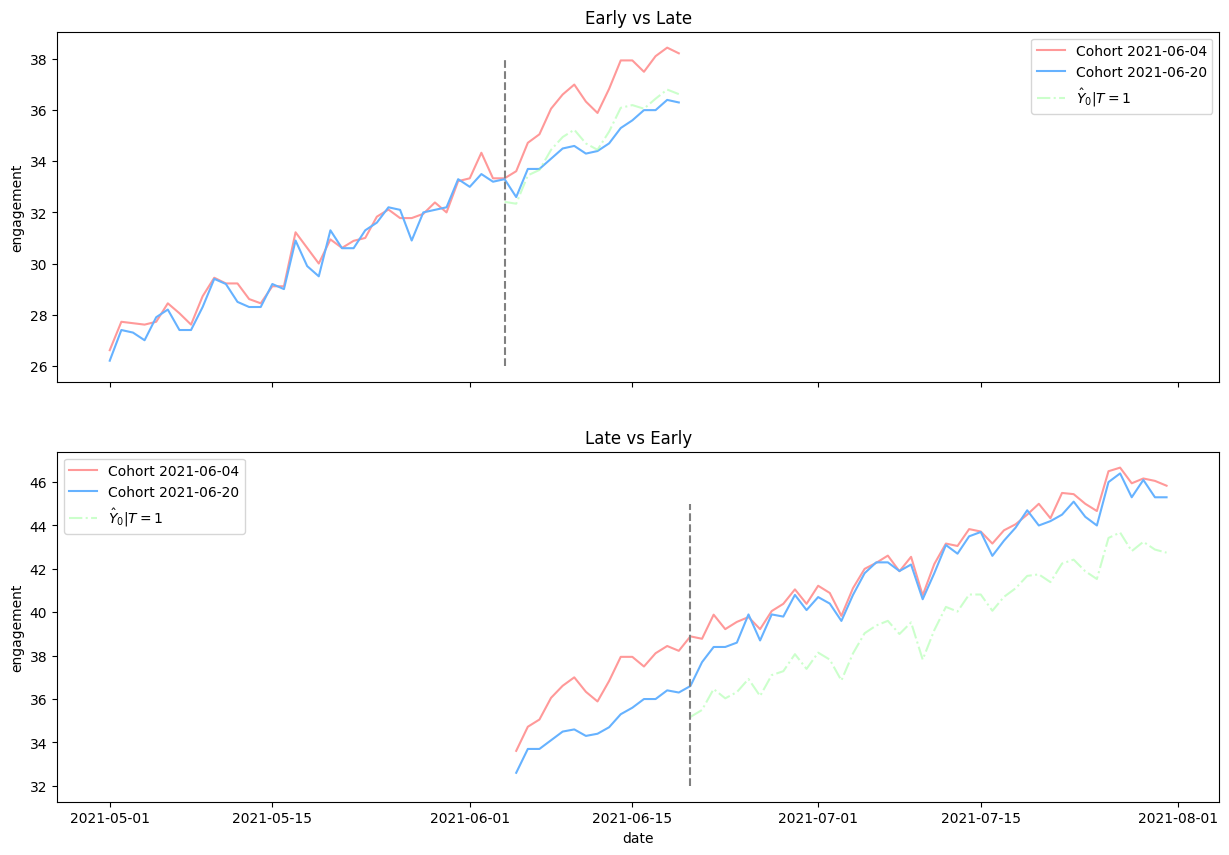

In [75]:
#####  색 넣어서

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

cohort_erly='2021-06-04'
cohort_late='2021-06-20'

# 색상 정의
color_early = '#FF9999'  # 연한 빨강
color_late = '#66B2FF'   # 연한 파랑
color_counterfactual = '#99FF99'  # 연한 초록

## Early vs Late
did_df = (mkt_data_cohorts_w
            .loc[lambda d: d["date"].astype(str) < cohort_late]
            .query(f"cohort=='{cohort_late}' | cohort=='{cohort_erly}'")
            .assign(treated = lambda d: (d["cohort"] == cohort_erly)*1,
                    post = lambda d: (d["date"].astype(str) >= cohort_erly)*1))

m = smf.ols(
    "engagement ~ treated:post + C(date) + C(city)",
    data=did_df
).fit()

plt_data = (did_df
            .assign(installs_hat_0 = lambda d: m.predict(d.assign(treated=0)))
            .groupby(["date", "cohort"])
            [["engagement", "post", "treated", "installs_hat_0"]]
            .mean()
            .reset_index())

sns.lineplot(data=plt_data.query("cohort==@cohort_erly"), x="date", y="engagement", color=color_early, label=f'Cohort {cohort_erly}', ax=ax1)
sns.lineplot(data=plt_data.query("cohort==@cohort_late"), x="date", y="engagement", color=color_late, label=f'Cohort {cohort_late}', ax=ax1)
sns.lineplot(data=plt_data.query("treated==1 & post==1"),
             x="date", y="installs_hat_0", color=color_counterfactual, ax=ax1, ls="-.", alpha=0.5, label="$\hat{Y}_0|T=1$")

ax1.vlines(pd.to_datetime(cohort_erly), 26, 38, ls="dashed", color='gray')
ax1.legend()
ax1.set_title("Early vs Late")

## Late vs Early
did_df = (mkt_data_cohorts_w
            .loc[lambda d: d["date"].astype(str) > cohort_erly]
            .query(f"cohort=='{cohort_late}' | cohort=='{cohort_erly}'")
            .assign(treated = lambda d: (d["cohort"] == cohort_late)*1,
                    post = lambda d: (d["date"].astype(str) >= cohort_late)*1))

m = smf.ols(
    "engagement ~ treated*post + C(date) + C(city)",
    data=did_df
).fit()

plt_data = (did_df
            .assign(installs_hat_0 = lambda d: m.predict(d.assign(treated=0)))
            .groupby(["date", "cohort"])
            [["engagement", "post", "treated", "installs_hat_0"]]
            .mean()
            .reset_index())

sns.lineplot(data=plt_data.query("cohort==@cohort_erly"), x="date", y="engagement", color=color_early, label=f'Cohort {cohort_erly}', ax=ax2)
sns.lineplot(data=plt_data.query("cohort==@cohort_late"), x="date", y="engagement", color=color_late, label=f'Cohort {cohort_late}', ax=ax2)
sns.lineplot(data=plt_data.query("treated==1 & post==1"),
             x="date", y="installs_hat_0", color=color_counterfactual, ax=ax2, ls="-.", alpha=0.5, label="$\hat{Y}_0|T=1$")

ax2.vlines(pd.to_datetime("2021-06-20"), 32, 45, ls="dashed", color='gray')
ax2.legend()
ax2.set_title("Late vs Early")

### 8.7.1 시간에 따른 이질적 효과


In [55]:
formula = "engagement ~ treated:post:C(cohort):C(date) + C(city)+C(date)"

twfe_model = smf.ols(formula, data=mkt_data_cohorts_w).fit()

In [56]:
df_pred = (
    mkt_data_cohorts_w
    .query("post==1 & treated==1")
    .assign(y_hat_0=lambda d: twfe_model.predict(d.assign(treated=0)))
    .assign(effect_hat=lambda d: d["engagement"] - d["y_hat_0"])
)

print("Number of param.:", len(twfe_model.params))
print("True Effect: ", df_pred["tau"].mean())
print("Pred. Effect: ", df_pred["effect_hat"].mean())

Number of param.: 510
True Effect:  2.2625252108176266
Pred. Effect:  2.259766144685024


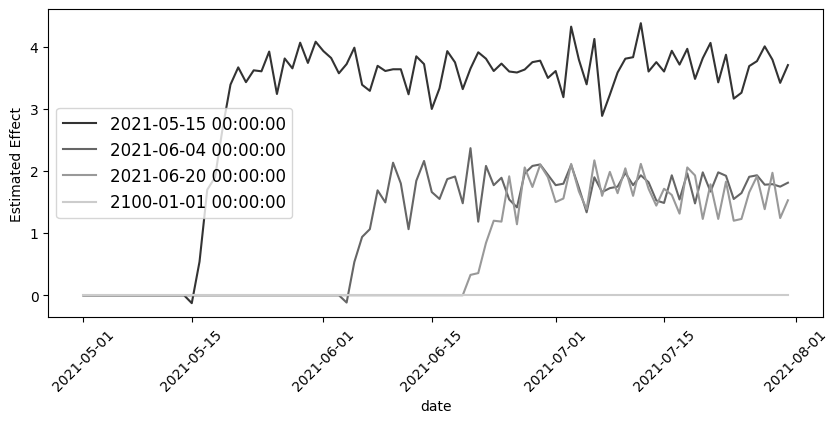

In [77]:
formula = "engagement ~ treated:post:C(cohort):C(date) + C(city) + C(date)"

twfe_model = smf.ols(formula, data=mkt_data_cohorts_w.astype({"date":str, "cohort": str})).fit()

effects = (twfe_model.params[twfe_model.params.index.str.contains("treated")]
           .reset_index()
           .rename(columns={0:"param"})
           .assign(cohort=lambda d: d["index"].str.extract(r'C\(cohort\)\[(.*)\]:'))
           .assign(date=lambda d: d["index"].str.extract(r':C\(date\)\[(.*)\]'))
           .assign(date=lambda d: pd.to_datetime(d["date"]), cohort=lambda d: pd.to_datetime(d["cohort"])))

plt.figure(figsize=(10,4))
sns.lineplot(data=effects, x="date", y="param", hue="cohort", palette="gray")
plt.xticks(rotation=45)
plt.ylabel("Estimated Effect")
plt.legend(fontsize=12)


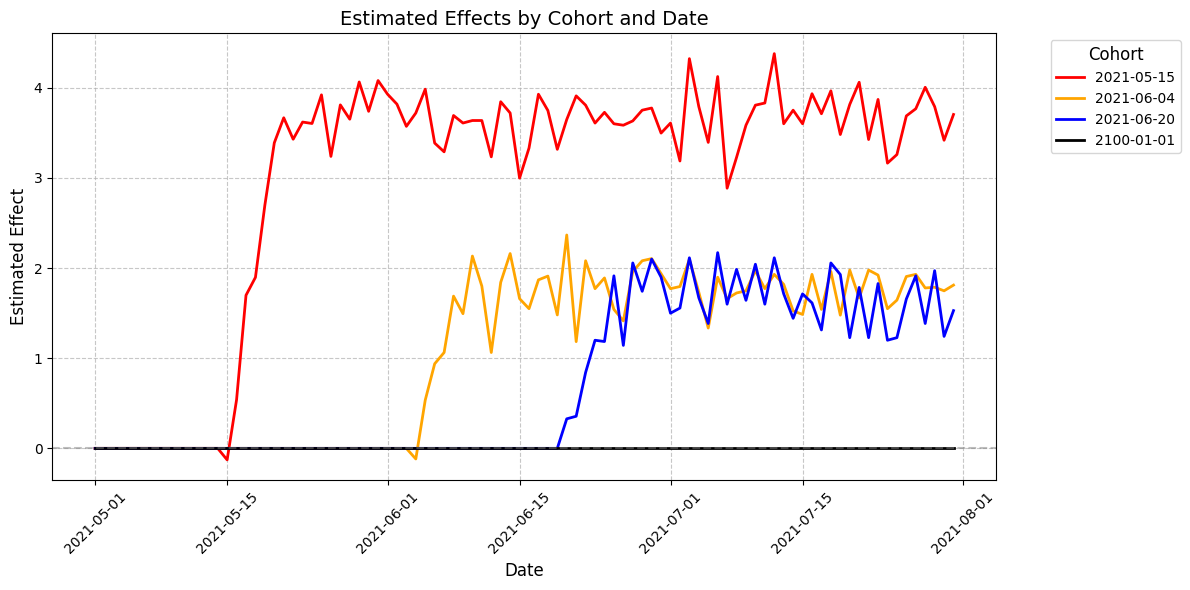

In [80]:
### 색 있게

formula = "engagement ~ treated:post:C(cohort):C(date) + C(city) + C(date)"

twfe_model = smf.ols(formula, data=mkt_data_cohorts_w.astype({"date":str, "cohort": str})).fit()

effects = (twfe_model.params[twfe_model.params.index.str.contains("treated")]
           .reset_index()
           .rename(columns={0:"param"})
           .assign(cohort=lambda d: d["index"].str.extract(r'C\(cohort\)\[(.*)\]:'))
           .assign(date=lambda d: d["index"].str.extract(r':C\(date\)\[(.*)\]'))
           .assign(date=lambda d: pd.to_datetime(d["date"]), cohort=lambda d: pd.to_datetime(d["cohort"])))

# 기본 색상 정의
colors = ['red', 'orange', 'blue', 'black', 'green', 'purple']

plt.figure(figsize=(12,6))

# 각 코호트에 대해 별도의 lineplot 생성
for i, cohort in enumerate(effects['cohort'].unique()):
    cohort_data = effects[effects['cohort'] == cohort]
    plt.plot(cohort_data['date'], cohort_data['param'], 
             color=colors[i % len(colors)], 
             linewidth=2, 
             label=cohort.strftime('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.ylabel("Estimated Effect", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.title("Estimated Effects by Cohort and Date", fontsize=14)

# 범례 개선
plt.legend(title="Cohort", title_fontsize='12', fontsize='10', bbox_to_anchor=(1.05, 1), loc='upper left')

# 그리드 추가
plt.grid(True, linestyle='--', alpha=0.7)

# y축 0에 수평선 추가
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
twfe_model = smf.ols(
    "engagement ~ treated:post + C(date) + C(city)",
    data=mkt_data_cohorts_w
).fit()

true_tau = mkt_data_cohorts_w.query("post==1&treated==1")["tau"].mean()

print("True Effect: ", true_tau)
print("Estimated ATT:", twfe_model.params["treated:post"])

True Effect:  2.2625252108176266
Estimated ATT: 1.759950478063391


# 질문 5
- 아래 코드는 어떤 실험 대상을 주체로 진행되는 과정인가요?

In [82]:
cohorts = sorted(mkt_data_cohorts_w["cohort"].unique())

treated_G = cohorts[:-1]
nvr_treated = cohorts[-1]

def did_g_vs_nvr_treated(df: pd.DataFrame,
                         cohort: str,
                         nvr_treated: str,
                         cohort_col: str = "cohort",
                         date_col: str = "date",
                         y_col: str = "engagement"):
    did_g = (
        df
        .loc[lambda d:(d[cohort_col] == cohort)|
                      (d[cohort_col] == nvr_treated)]
        .assign(treated = lambda d: (d[cohort_col] == cohort)*1)
        .assign(post = lambda d:(pd.to_datetime(d[date_col])>=cohort)*1)
    )
    
    att_g = smf.ols(f"{y_col} ~ treated*post",
                    data=did_g).fit().params["treated:post"]
    size = len(did_g.query("treated==1 & post==1"))
    return {"att_g": att_g, "size": size}


atts = pd.DataFrame(
    [did_g_vs_nvr_treated(mkt_data_cohorts_w, cohort, nvr_treated)
     for cohort in treated_G]
)
    
atts

,att_g,size
0,3.455535,702
1,1.659068,1044
2,1.573687,420


In [83]:
(atts["att_g"]*atts["size"]).sum()/atts["size"].sum()

2.224746774055868

### 8.7.2 공변량


In [84]:
formula = """
engagement ~ treated:post:C(cohort):C(date)"""

twfe_model = smf.ols(formula, data=mkt_data_cohorts).fit()

In [85]:
df_pred = (
    mkt_data_cohorts
    .query("post==1 & treated==1")
    .assign(y_hat_0=lambda d: twfe_model.predict(d.assign(treated=0)))
    .assign(effect_hat=lambda d: d["engagement"] - d["y_hat_0"])
)

print("Number of param.:", len(twfe_model.params))
print("True Effect: ",  df_pred["tau"].mean())
print("Pred. Effect: ", df_pred["effect_hat"].mean())

Number of param.: 369
True Effect:  2.078397729895905
Pred. Effect:  3.6642633938864817
